1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats

In [2]:
bound = [(-2,2),(-1,1)]
results = []
def f(x):
    return (4 - 2.1*(x[0]**2) + (x[0]**4)/3) * (x[0]**2) + (x[0]*x[1]) + (4*(x[1]**2) - 4)*(x[1]**2)
for i in range(10):
    res = optimize.minimize(f, np.random.uniform(-1,1,size=2), method='CG') # starting from different points
    if res.success:
        results.append(res.x)
    else:
        print("no minimum found")
results = np.array(results)
print(results)

[[ 0.08984241 -0.71265652]
 [ 0.08984198 -0.71265652]
 [ 0.08984192 -0.71265627]
 [-0.08984205  0.71265595]
 [-0.08984202  0.71265638]
 [ 0.08984201 -0.71265641]
 [ 0.089842   -0.7126564 ]
 [ 0.08984201 -0.71265641]
 [-0.08984196  0.71265633]
 [-0.08984202  0.71265632]]


res_0: [0. 0.]


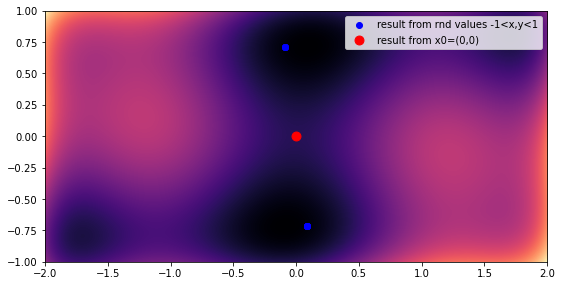

In [3]:
xx = np.linspace(-2, 2, 1000)
yy = np.linspace(-1, 1, 1000)
x, y = np.meshgrid(xx, yy)
Z = f([x,y])

fig = plt.figure(figsize=(9, 6))
plt.imshow(Z, extent=[-2, 2, -1, 1], cmap='magma')
plt.scatter(results[:,0], results[:,1], color ='blue', label="result from rnd values -1<x,y<1")

x_start0 = [0, 0]
res_0 = np.array(optimize.minimize(f, x_start0, method='CG').x)
print("res_0:", res_0)
plt.scatter(res_0[0], res_0[1], marker='o', s=80, color ='red', label="result from x0=(0,0)")
plt.legend()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

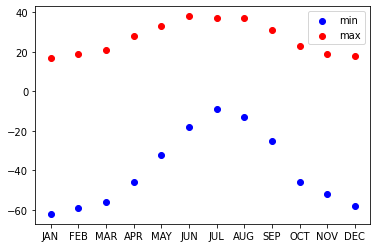

In [4]:
minT = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58] 
maxT = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
plt.scatter(months, minT, color='blue',label='min')
plt.scatter(months, maxT, color='red', label='max')
plt.legend()
plt.show()

parameters for the min temperatures:
 [ 52.64929231   7.16452595  -1.97590019 -61.32093708]
parameters for the max temperatures:
 [23.09206731  6.73581537 -2.29443052 15.77935194]


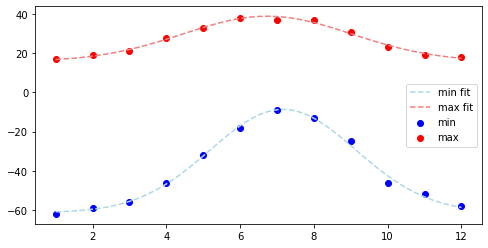

In [5]:
# def func(x, mu, sig, q, a):
#     return a * (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))) + q
def func(x, A, mu, sig, off):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))+ off
x_month, x = np.linspace(1,12,12), np.linspace(1,12,100)
popt_min, pcov_min = optimize.curve_fit(func, x_month, minT, [1,1,1,1])
print("parameters for the min temperatures:\n", popt_min)
popt_max, pcov_max = optimize.curve_fit(func, x_month, maxT, [1,1,1,1])
print("parameters for the max temperatures:\n", popt_max)
# printing the scatters and the fits
plt.figure(figsize=(8, 4))
plt.scatter(x_month, minT, color='blue',label='min')
plt.plot(x, func(x, *popt_min), color='lightblue', linestyle='dashed', label='min fit')
plt.scatter(x_month, maxT, color='red', label='max')
plt.plot(x, func(x, *popt_max), color='lightcoral', linestyle='dashed', label='max fit')
plt.legend(loc='best')
plt.show()

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [14]:
filename = r'C:\Users\Marco\Downloads\residuals_261.pkl'
data=np.load(filename, allow_pickle=True).item()
df = pd.DataFrame(data['residuals'], columns=['residuals'])
len(df)

11131

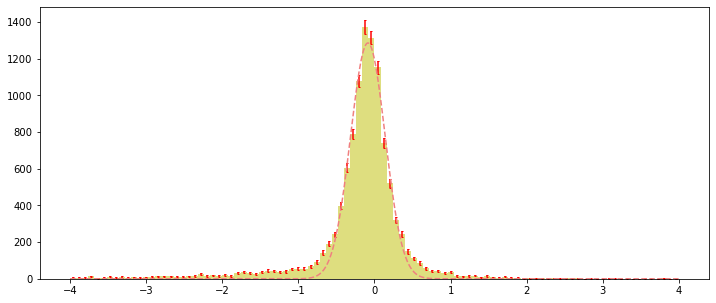

In [15]:
fig = plt.figure(figsize=(12,5))
nbins = 100
counts, bins, _ = plt.hist(df['residuals'], bins=nbins, range=[-4, 4], color='y', alpha=0.5)
x_hist = (bins[1:] + bins[:-1])/2
yerr = [np.sqrt(x) for x in counts]
plt.errorbar(x_hist, counts, yerr=yerr, linestyle=' ', color='r', capsize=1)
def gaus(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
x = np.linspace(bins[0], bins[-1], 1000)
popt, pcov = optimize.curve_fit(gaus, x_hist, counts)
y = gaus(x, *popt)
plt.plot(x, y, color='lightcoral', linestyle='dashed', label='max fit')

In [8]:
ndof = len(df) - 1
# calculate the chi^2
b_hat = pcov[0, 1] / pcov[0, 0]
a_hat = np.mean(y - b_hat * x)
sigma_y = np.sqrt(np.abs(y))
chi2 = np.sum(((y - (a_hat + b_hat * x))**2) / sigma_y)
ndof = len(popt) - 1
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
if pvalue > 0.05 and pvalue <= 1.00:
    print("p-value:", pvalue, ", the fit is satisfactory")
elif pvalue < 0.05:
    print("p-value:", pvalue, ", the fit is unsatisfactory")
else:
    print("error")

p-value: 0.0 , the fit is unsatisfactory


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [9]:
filename = r'C:\Users\Marco\Downloads\munich_temperatures_average_with_bad_data.txt'
df = pd.read_csv(filename, sep=" ", header=None) # i used read_csv setting the options to read a text file
df.columns = ['day', 'T']

def f(t, a, b, c):
    return a * np.cos(2*np.pi*t + b) + c
df1 = df[(df['day']>2008) & (df['day']<2013)]
df1

,day,T
4748,2008.00274,-2.94444
4749,2008.00548,-2.66667
4750,2008.00821,-2.66667
4751,2008.01095,-2.00000
4752,2008.01369,-1.94444
...,...,...
6569,2012.98836,6.88889
6570,2012.99110,7.05556
6571,2012.99384,3.77778
6572,2012.99658,1.83333


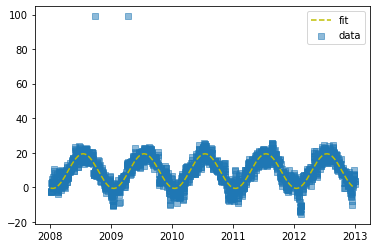

parameters for the function:
 [-10.01800059  12.3254922    9.35102928]


In [10]:
f_pars, fcov = optimize.curve_fit(f, df1['day'], df1['T'])
plt.scatter(df1['day'], df1['T'], alpha=0.5, marker=',', label="data")
plt.plot(df1['day'], f(df1['day'], *f_pars), 'y--', label="fit")
plt.legend(loc='best')
plt.show()
print("parameters for the function:\n", f_pars)

mean T: 8.94190703859861
the typical daily average values predicted by the model for the coldest and hottest time of year are:
-0.6669713176267233 19.36902985166563


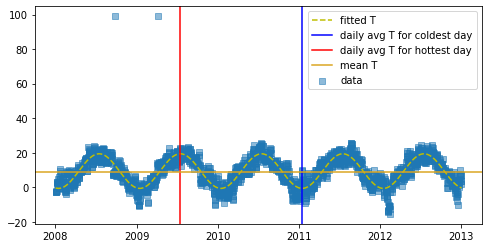

In [11]:
mean = np.mean(df['T'])
print("mean T:", mean)
solution_min = optimize.minimize_scalar(f, args=(*f_pars,), method='bounded', bounds=(2008, 2013))
def f_minus(t, a, b, c):
    return -a * np.cos(2*np.pi*t + b) - c
solution_max = optimize.minimize_scalar(f_minus, args=(*f_pars,), method='bounded', bounds=(2008, 2013))
print("the typical daily average values predicted by the model for the coldest and hottest time of year are:")
print(solution_min['fun'], -1*solution_max['fun'])
plt.figure(figsize=(8, 4))
plt.scatter(df1['day'], df1['T'], alpha=0.5, marker=',', label="data")
plt.plot(df1['day'], f(df1['day'], *f_pars), 'y--', label="fitted T")
plt.axvline(solution_min['x'], color='b', label="daily avg T for coldest day")
plt.axvline(solution_max['x'], color='r', label="daily avg T for hottest day")
plt.axhline(mean, color='goldenrod', linestyle='-',  label="mean T")
plt.legend(loc='upper right')
plt.show()

What is the meaning of the  𝑏  parameter, and what physical sense does it have?
> it is the phase of the trigonometric function cos and physically means that the minimum value of T is out of phase by b

In [12]:
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

SSR f: 40376.57222825893 SSR g: 40375.2799793471
Test f vs g:
CL: 0.809 , additional parameter necessary: NO


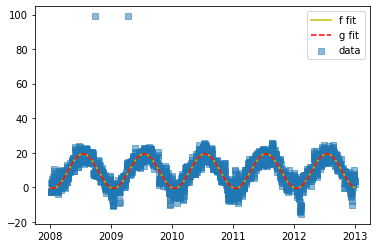

In [13]:
def g(t, a, b, c, d):
    return a * np.cos(2*np.pi*b*t + c) + d

g_pars, gcov = optimize.curve_fit(g, df1['day'], df1['T'])
yf = f(df1['day'], *f_pars)
yg = g(df1['day'], *g_pars)
y = df1['T']
ssr_f = np.sum((yf - y)**2)
ndof_f = len(f_pars) - 1
ssr_g = np.sum((yg - y)**2)
ndof_g = len(g_pars) - 1
print("SSR f:", ssr_f, "SSR g:", ssr_g)

print("Test f vs g:")
cl_f_vs_g = Ftest(ssr_f, ssr_g, ndof_f, ndof_g, len(df1), verbose=True)

plt.scatter(df1['day'], df1['T'], alpha=0.5, marker=',', label="data")
plt.plot(df1['day'], f(df1['day'], *f_pars), 'y-', label="f fit")
plt.plot(df1['day'], g(df1['day'], *g_pars), 'r--', label="g fit")
plt.legend(loc='best')
plt.show()